<a href="https://colab.research.google.com/github/KelvinLam05/Topic-Modelling/blob/main/Topic_Modelling_Discovering_Topics_from_Reviews_with_Latent_Dirichlet_Allocation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Topic Modelling:**

Topic modeling is another popular text analysis technique. The ultimate goal of topic modeling to find a theme across reviews, and discover hidden topics. Each document in the corpus will be made up of at least one topic, if not multiple topics.

**Goal of the project**

In this notebook, we will be covering the steps on how to do **Latent Dirichlet Allocation (LDA)**, which is one of many topic modeling techniques. It’s an unsupervised classification method. When we have a large text and don’t know where to start, then we can apply topic modeling and can see what kind of groups are emerging. LDA was specifically designed for text data.

**Importing the data**

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [2]:
# Load dataset
df = pd.read_csv('/content/restaurant_reviews.tsv', sep = '\t')

In [3]:
# Examine the data
df.head()

,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [4]:
# Overview of all variables, their datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  1000 non-null   object
 1   Liked   1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


**Data preprocessing**

In [5]:
# Change column names to lower case
df.columns = df.columns.str.lower()

In [6]:
# Drop columns that are not needed
df.drop('liked', axis = 1, inplace = True)

In [7]:
df.head()

,review
0,Wow... Loved this place.
1,Crust is not good.
2,Not tasty and the texture was just nasty.
3,Stopped by during the late May bank holiday of...
4,The selection on the menu was great and so wer...


In [8]:
# Checking for missing values
df.isnull().sum().sort_values(ascending = False)

review    0
dtype: int64

In [9]:
# Find all unique characters and symbols 
all_text = str()

for sentence in df['review'].values:
    all_text += sentence
    
''.join(set(all_text))

'8ZjtXi:&Ug9YWM)T\'c-qhAsCr%7nSBumJdwe5f$" OQ2élzaê?(VDx*p.HR4ybEG0LkPF6+vN3I/1Ko!,'

The kind of data we get from customer feedback is usually unstructured. It contains unusual text and symbols that need to be cleaned so that a machine learning model can grasp it.

In [10]:
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 

In [11]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [12]:
stop_words = set(stopwords.words('english'))  

We use the WordNet lemmatizer from NLTK. A lemmatizer is preferred over a stemmer in this case because it produces more readable words. Output that is easy to read is very desirable in topic modelling.

In [13]:
lemma = WordNetLemmatizer()

We will now set up our cleaning function.

In [14]:
def clean_review(review_text):

  # Removing all irrelevant characters (numbers and punctuation)                           
  review_text = re.sub('[^a-zA-Z]', ' ', review_text)                           
  # Replace one or more spaces with single space
  review_text = re.sub(r'\s+', ' ', review_text)                                
  # Convert all characters into lowercase
  review_text = str(review_text).lower()                                        
  # Tokenization
  review_text = word_tokenize(review_text)        
  # Removing Stopwords                                      
  review_text = [item for item in review_text if item not in stop_words]
  # Lemmatization
  review_text = [lemma.lemmatize(word = w, pos = 'v') for w in review_text]     
  # Remove the words having length <= 2
  review_text = [i for i in review_text if len(i) > 2]                          
  # Convert the list of tokens into back to the string
  review_text = ' '.join (review_text)                                          
  
  return review_text 

In [15]:
df['clean_review'] = df['review'].apply(clean_review)

In [16]:
all_text = str()

for sentence in df['clean_review'].values:
    all_text += sentence
    
''.join(set(all_text))

'fysbrj ktinlgzuvmacodxwpqeh'

When working with unstructured text data, we will inevitably find misspelled words. Luckily, SpellChecker can fix this.

In [18]:
from spellchecker import SpellChecker

In [19]:
# Instantiate spell checker
spell = SpellChecker()

In [20]:
# Correct spelling
def correct_spellings(text):
    
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    
    return ' '.join(corrected_text)

In [21]:
df['clean_review'] = df['clean_review'].apply(correct_spellings)

In [22]:
# Get the first five rows
df['review'].head()

0                             Wow... Loved this place.
1                                   Crust is not good.
2            Not tasty and the texture was just nasty.
3    Stopped by during the late May bank holiday of...
4    The selection on the menu was great and so wer...
Name: review, dtype: object

In [23]:
# Get the first five rows
df['clean_review'].head()

0                                       wow love place
1                                           crust good
2                                  tasty texture nasty
3    stop late may bank holiday rick steve recommen...
4                           selection menu great price
Name: clean_review, dtype: object

In [24]:
import spacy.cli

In [25]:
spacy.cli.download('en_core_web_sm')

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [26]:
import en_core_web_sm

In [27]:
nlp = en_core_web_sm.load()

In [28]:
# Let's create a function to pull out nouns, verbs, adjectives, and adverbs from a string of text
def is_pos(text):
    
    doc = nlp(text)
    txt = []
    is_pos = lambda pos: pos[:2] == 'VB' or pos[:2] == 'RB' or pos[:2] == 'NN' or pos[:2] == 'JJ' 
    
    for token in doc:
        txt.append((token.text, token.tag_))
    word_pos = [word for (word, pos) in txt if is_pos(pos)] 
    
    return ' '.join(word_pos)

In [29]:
df['clean_review'] = df['clean_review'].apply(is_pos)

In [30]:
# Get the first five rows
df['clean_review'].head()

0                                           love place
1                                           crust good
2                                  tasty texture nasty
3    stop late may bank holiday rick steve recommen...
4                           selection menu great price
Name: clean_review, dtype: object

After every preprocessing step, it is a good practice to check the most frequent words in the data. Therefore, let’s define a function that would plot a bar graph of n most frequent words in the data.

In [31]:
# Split the reviews into tokens
df['clean_review'] = df['clean_review'].str.split()

In [32]:
df['clean_review'].head()

0                                        [love, place]
1                                        [crust, good]
2                              [tasty, texture, nasty]
3    [stop, late, may, bank, holiday, rick, steve, ...
4                      [selection, menu, great, price]
Name: clean_review, dtype: object

In [33]:
from nltk import FreqDist

Text(0.5, 1.0, 'Frequency Distribution')

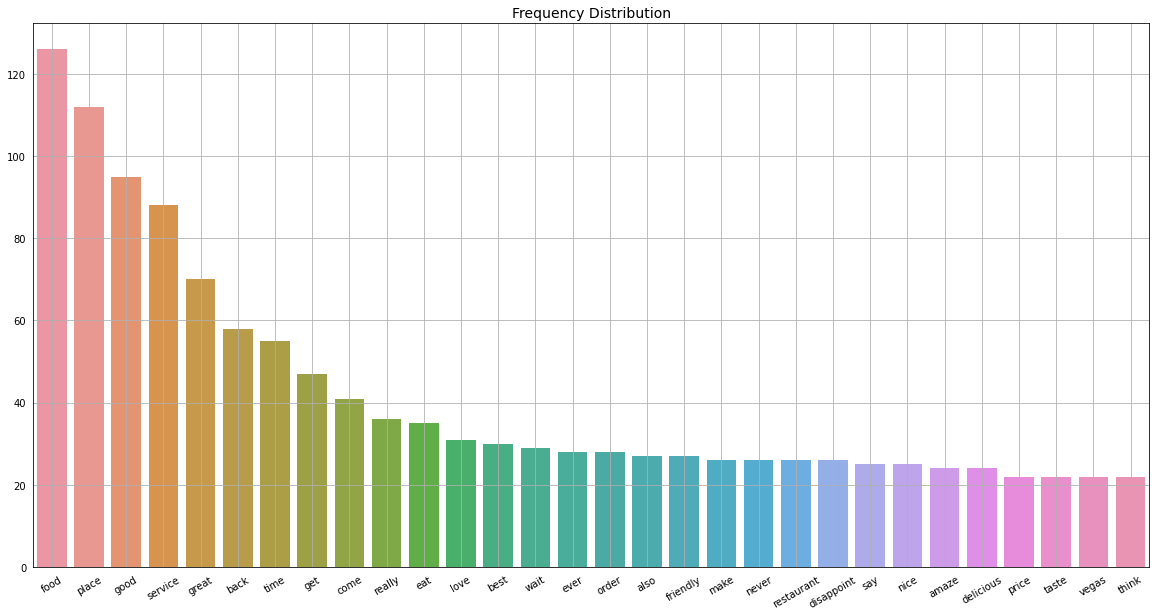

In [34]:
# First get a list of all words
all_words = [word for item in list(df['clean_review']) for word in item]

# Creating FreqDist for whole BoW, keeping the 30 most common tokens
all_fdist = FreqDist(all_words).most_common(30)

# Conversion to Pandas series via Python Dictionary for easier plotting
all_fdist = pd.Series(dict(all_fdist))

# Setting figure, ax into variables
fig, ax = plt.subplots(figsize = (20, 10))

# Seaborn plotting using Pandas attributes + xtick rotation for ease of viewing
all_plot = sns.barplot(x = all_fdist.index, y = all_fdist.values, ax = ax)
plt.grid()
plt.xticks(rotation = 30)
plt.tick_params(left = False, bottom = False)
plt.title('Frequency Distribution', {'fontsize': 14})

**Bag of Words**

Create a dictionary from ‘clean_review’ containing the number of times a word appears in the training set.


In [35]:
from gensim import corpora

In [36]:
# Creating term dictionary of corpus, where each unique term is assigned an index
dictionary = corpora.Dictionary(df['clean_review'])

We remove rare words and common words based on their document frequency. Below we remove words that appear in less than 4 documents or in more than 40% of the documents.

In [37]:
# Filter out words that occur less than 4 documents, or more than 40% of the documents
dictionary.filter_extremes(no_below = 4, no_above = 0.4)

For each document we create a dictionary reporting how many
words and how many times those words appear. 

In [38]:
# Bag-of-words representation of the documents
doc_term_matrix = df['clean_review'].map(dictionary.doc2bow)

Let’s see how many tokens and documents we have to train on.

In [39]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(doc_term_matrix))

Number of unique tokens: 307
Number of documents: 1000


**Running LDA using Bag of Words**

With the dictionary and doc_term_matrix ready, now we can Train the LDA model using **gensim.models.ldamodel.LdaModel.**

However, at this point, the next question we need to ask is that what is the number of topics (k) should we use to train our model? We can utilize the c_v coherence score and the pyLDAvis visualization tool to decide the optimum number of topics for our model.

Calculate the c_v Coherence Score:

In [40]:
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel

In [41]:
# Compute c_v coherence for various number of topics
def compute_coherence_values(dictionary, corpus, texts, limit, start = 2, step = 3):
    
    """
    
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    
    """
    
    coherence_values = []
    model_list = []
    
    for num_topics in range(start, limit, step):
        
        model = LdaModel(corpus = doc_term_matrix, id2word = dictionary, num_topics = num_topics, random_state = 42, update_every = 1, chunksize = 2000, passes = 50, alpha = 'auto', eta = 'auto', per_word_topics = True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model = model, texts = df['clean_review'], dictionary = dictionary, coherence = 'c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

We can find the optimal number of topics for LDA by creating many LDA models with various values of topics. Among those LDAs we can pick one having highest coherence value.

Following function named coherence_values_computation( ) will train multiple LDA models. It will also provide the models as well as their corresponding coherence score.

In [42]:
model_list, coherence_values = compute_coherence_values(dictionary = dictionary, corpus = doc_term_matrix, texts = df['clean_review'], start = 2, limit = 40, step = 4)

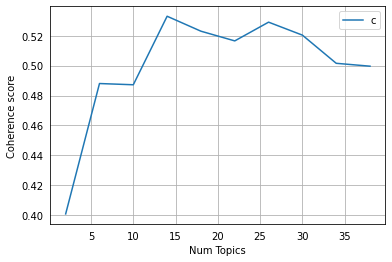

In [43]:
# Show graph
limit = 40; start = 2; step = 4;

x = range(start, limit, step)

plt.plot(x, coherence_values)
plt.grid()
plt.xlabel('Num Topics')
plt.ylabel('Coherence score')
plt.legend(('coherence_values'), loc = 'best')
plt.tick_params(left = False, bottom = False)
plt.show()

In [44]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4008
Num Topics = 6  has Coherence Value of 0.488
Num Topics = 10  has Coherence Value of 0.4872
Num Topics = 14  has Coherence Value of 0.533
Num Topics = 18  has Coherence Value of 0.523
Num Topics = 22  has Coherence Value of 0.5165
Num Topics = 26  has Coherence Value of 0.5291
Num Topics = 30  has Coherence Value of 0.5204
Num Topics = 34  has Coherence Value of 0.5016
Num Topics = 38  has Coherence Value of 0.4996


Now, the question arises which model should we pick now? One of the good practices is to pick the model, that is giving highest coherence value before flattering out. So that’s why, we will be choosing the model with 14 topics which is at number 4 in the above list.

In [45]:
from pprint import pprint

In [46]:
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted = False)
pprint(optimal_model.print_topics(num_topics = -1, num_words = 10))

[(0,
  '0.071*"time" + 0.058*"place" + 0.051*"give" + 0.048*"star" + 0.044*"first" '
  '+ 0.042*"vegas" + 0.035*"experience" + 0.034*"know" + 0.028*"back" + '
  '0.027*"bad"'),
 (1,
  '0.065*"even" + 0.062*"much" + 0.053*"order" + 0.034*"fresh" + 0.032*"food" '
  '+ 0.027*"good" + 0.022*"really" + 0.022*"come" + 0.019*"quick" + '
  '0.018*"best"'),
 (2,
  '0.156*"place" + 0.057*"amaze" + 0.045*"food" + 0.041*"really" + '
  '0.038*"recommend" + 0.035*"flavor" + 0.032*"definitely" + 0.030*"say" + '
  '0.030*"way" + 0.024*"nice"'),
 (3,
  '0.076*"love" + 0.049*"place" + 0.046*"service" + 0.037*"worst" + '
  '0.037*"find" + 0.033*"terrible" + 0.033*"pretty" + 0.030*"waitress" + '
  '0.029*"food" + 0.028*"ever"'),
 (4,
  '0.140*"service" + 0.066*"friendly" + 0.054*"staff" + 0.052*"also" + '
  '0.027*"check" + 0.027*"slow" + 0.024*"cold" + 0.021*"night" + '
  '0.020*"attentive" + 0.019*"time"'),
 (5,
  '0.206*"good" + 0.075*"food" + 0.036*"service" + 0.027*"tasty" + '
  '0.026*"pizza" + 0.02

We can see that the topics above make a lot of sense. However, they are not without flaws. We can see that there is substantial overlap between some topics, others are hard to interpret, and most of them have at least some terms that seem out of place. 

**Topic Model Visualization**

To visualize our topics in a 2-dimensional space we will use the pyLDAvis library. This visualization is interactive in nature and displays topics along with the most relevant words.

In [47]:
import pyLDAvis
import pyLDAvis.gensim_models

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_lda.py:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


In [48]:
model = LdaModel(corpus = doc_term_matrix, id2word = dictionary, num_topics = 14, random_state = 42, update_every = 1, chunksize = 2000, passes = 50, alpha = 'auto', eta = 'auto', per_word_topics = True)

Streaminguitvoer ingekort tot de laatste 5000 regels.
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(

In [49]:
# Visualize the topics
vis = pyLDAvis.gensim_models.prepare(topic_model = model, corpus = doc_term_matrix, dictionary = dictionary, sort_topics = False, mds = 'mmds')

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted t

In [50]:
pyLDAvis.display(vis)

For k = 14, the topics are well separated in different quadrants.